## Notebook for data acquisition and analysis
### Physics 108, Winter 2017-18
#### Authors: Alex Rickman, Connor Holland, Joey Murphy

In [1]:
import numpy as np
import visa
import time
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Data acquisition via GPIB

Data is being acquired using two HP 34401A DMMs in parallel, making sequential voltage measurements of the reference and signal.

In [12]:
# Run this cell to load the lab setup instruments. 
rm = visa.ResourceManager()
instr_ref    = rm.open_resource('GPIB0::2::INSTR') # DMM measuring function generator output
instr_signal = rm.open_resource('GPIB0::3::INSTR') # DMM measuring signal output
scope = rm.open_resource('GPIB0::7::INSTR')        # Oscilloscope

In [18]:
# Dictionary that holds values for parameters in our lab setup
lab_params = {'srs_gain':1.0*10e4, 'ref_ampl_Vpp':20.0, 'ref_freq_Hz':0.5, 'box_resistor':9.96 * 10e4, 'low_pass_cut_Hz':3.0, 
             'low_pass_roll_dB':12.0, 'high_pass_cut_Hz':None, 'high_pass_roll_dB':None}

In [17]:
# Save lab parameters to file. Not necessary to run
with open('lab_params_{}.json'.format(time.strftime("%m_%d_%Y-%H_%M_%S")), 'w') as fp:
    json.dump(lab_params, fp, sort_keys=True, indent=4)

In [ ]:
# Load the parameters from a stored lab set up
with open('PARAM_FILENAME.json', 'r') as fp:
    lab_params = json.load(fp)

In [24]:
# Call this function to take sequential voltage measurements of reference and signal for a time meas_time (in seconds)

def take_data(instr_ref, instr_signal, lab_params, meas_time=60*2, save_to_file=True, filename=None):

    time_start = time.perf_counter()
    time_stop = time_start + meas_time
    
    # Lists to hold the measurement data
    t_ref = []
    t_signal = []
    voltage_ref = []
    voltage_signal = []
    
    # Take sequential voltage measurements
    while time.perf_counter() <= time_stop:
        
        # Note the time and take a measurement of the reference voltage
        t_ref.append(time.perf_counter())
        voltage_ref.append(float(instr_ref.query('MEAS:VOLT:DC?')))
        
        # Note the time and take a measurement of the signal voltage
        t_signal.append(time.perf_counter())
        voltage_signal.append(float(instr_signal.query('MEAS:VOLT:DC?')))

    # Set measurement start time to zero. Convert data lists to numpy arrays so they're easier to work with.
    t_ref = np.asarray(t_ref) - time_start
    t_signal = np.asarray(t_signal) - time_start
    voltage_ref = np.asarray(voltage_ref)
    voltage_signal = np.asarray(voltage_signal)
    
    # Scale the signal voltage depending on the gain of the SRS pre-amp
    voltage_signal = (1/lab_params['srs_gain']) * voltage_signal

    # Zip the data together so it's in the format [(t_0, v_0), (t_1 , v_1), ..., (t_N, v_N)]
    data_ref = np.array(list(zip(t_ref, voltage_ref)))
    data_signal = np.array(list(zip(t_signal, voltage_signal)))
    
    # If the user would like to save the data to .txt file
    if save_to_file:
        
        # If the user did not specifiy a filename they'd like to use, just save it to an arbitrary file.
        if filename is None:
            timestr = time.strftime("%m_%d_%Y-%H_%M_%S")
            # Save the data to .txt files
            np.savetxt('data/{}_ref.txt'.format(timestr), data_ref)
            np.savetxt('data/{}_signal.txt'.format(timestr), data_signal)
        
        # If the client specified their own filename they'd like to use
        elif filename is not None:
            np.savetxt(filename + '_ref.txt', data_ref)
            np.savetxt(filename + '_signal.txt', data_signal)
            
    return data_ref, data_signal

In [25]:
# Run this cell to take data
data_ref, data_signal = take_data(instr_ref, instr_signal, lab_params, meas_time=60*1) # Initially take 2 min of data

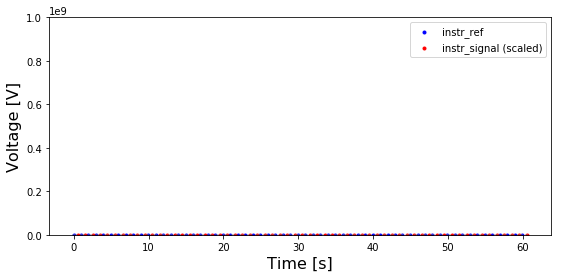

In [37]:
plot_data(data_ref, data_signal, lab_params)

In [2]:
# Use this cell to load data from a file if you want to do postprocessing on it
##### Uncomment and change variable/file names if needed #####
# t_ref, voltage_ref = np.loadtxt('FILENAME.txt', unpack=True)
# t_signal, voltage_signal = np.loadtxt('FILENAME.txt', unpack=True)

In [36]:
# Plot the data
def plot_data(data_ref, data_signal, lab_params, save_fig=True, filename=None):
    
    # Declare a figure for plotting
    fig, ax = plt.subplots(figsize=(9,4))
    
    # Unpack the data
    t_ref, voltage_ref = zip(*data_ref)
    t_signal, voltage_signal = zip(*data_signal)
    
    # Apply the correct scaling so that we can plot both signals in real units
    # TODO:
    # 0000000000000000000000000000000000000
    # Get the correct constants from the lab_params dictionary
    
    # Plot the data on a scatter plot
    ax.scatter(t_ref, voltage_ref, marker='.', color='blue', label='instr_ref')
    ax.scatter(t_signal, voltage_signal, marker='.', color='red', label='instr_signal (scaled)')

    # Reference line at 0 Volts
    ax.plot(np.linspace(-0.25, max(t_signal) + 0.25, 100), np.zeros(100), '--', color='gray', alpha=0.5)

    # Set labels for axes
    ax.set_xlabel('Time [s]', fontsize=16)
    ax.set_ylabel('Voltage [V]', fontsize=16)
    ax.set_ylim([-1*10e-8, 10e8])
    ax.legend()
    
    # If the user would like to save the figure to file
    if save_fig:
        
        # If the user did not specifiy a filename they'd like to use, just save it to an arbitrary file.
        if filename is None:
            timestr = time.strftime("%m_%d_%Y-%H_%M_%S")
            # Save the data to .txt files
            fig.savefig('figures/{}_data_plot.pdf'.format(timestr))
        
        # If the client specified their own filename they'd like to use
        elif filename is not None:
            fig.savefig('figures/' + filename + '_data_plot.pdf')
            
    plt.show()